# 👽👾 `print(fiction)` 📚🛸

> #### A data science project by _Tobias Reaper_

#### 📓 Notebook 3: Modeling 🧠

---

### Notebook Outline

[explanation of this notebook in context of project]

* Intro
* Imports and Configuration

---

## Introduction

`print(fiction)` is a solo project I worked on to explore the data on and around stories—specifically, the stories contained in print books.

I used Scrapy to scrape metadata for over 20,000 books from GoodReads and used it to train a gradient-boosted random forest classifier. The final version of the model classified books as either fiction or nonfiction with 88% accuracy.

The dataset is freely available for download from GitHub or Kaggle (link to come).
I built an interactive dashboard using Plotly Dash that can be used to tinker with the model parameters and view the resulting prediction in real time.

You can find the current live version of the app here: [print(fiction)](http://print-fiction.herokuapp.com/)

The notebooks detailing the entire process of data gathering, wrangling, modeling, and deployment, can be found here: [print(fiction) notebooks](https://github.com/tobias-fyi/print-fiction/tree/master/notebooks)

---

### Imports and Configuration

⚙️📥 

In [1]:
# === General Imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

In [2]:
# === Configure === #
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [3]:
# %%capture
# !pip install category-encoders
# !pip install eli5

In [4]:
# === ML Imports === #

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Model validation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Interpretations
import eli5
from eli5.sklearn import PermutationImportance

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


---

## 📈 Load Data

In [5]:
# === Load the dataset === #
# This version was exported from the previous notebook
# after doing some initial wrangling
data_path = "https://raw.githubusercontent.com/tobias-fyi/vela/master/ds/interview_prep/practice/print-fiction/assets/must_read_books-02.csv"

books = pd.read_csv(data_path, na_values="?")
print(books.shape)
books.head(3)

(18344, 18)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0,1
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,0,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0,1
2,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1,477.0,1521.0,9016.0,25447.0,47472.0,1974.0,1.0,1.0,1,1


In [6]:
# === Confirm null values were read in correctly === #
books.isnull().sum()

title                0
author               0
num_ratings          0
num_reviews          0
avg_rating           0
num_pages          666
language          1332
series               0
1_rating_count      83
2_rating_count      83
3_rating_count      83
4_rating_count      83
5_rating_count      83
publish_year       282
publish_month      282
publish_day        282
fiction              0
republish            0
dtype: int64

---

## Model validation

* Split data into train, validation, and test sets
* Choose an appropriate evaluation metric
* Get a baseline accuracy (or precision/recall)

In [7]:
# === Split data into train / val / test === #
train, test = train_test_split(books, stratify=books["fiction"], test_size=0.2, random_state=92)
train, val = train_test_split(train, stratify=train["fiction"], test_size=0.2, random_state=92)

train.shape, val.shape, test.shape

((11740, 18), (2935, 18), (3669, 18))

In [8]:
# === Set up target and features === #
target = "fiction"

# Arrange y vector
y_train = train[target]
y_val = val[target]
y_test = test[target]

print(y_train.shape, y_val.shape, y_test.shape)

# Arrange X matrices
X_train = train.drop(columns=[target])
X_val = val.drop(columns=[target])
X_test = test.drop(columns=[target])

print(X_train.shape, X_val.shape, X_test.shape)

(11740,) (2935,) (3669,)
(11740, 17) (2935, 17) (3669, 17)


1    6145
0    5595
Name: fiction, dtype: int64


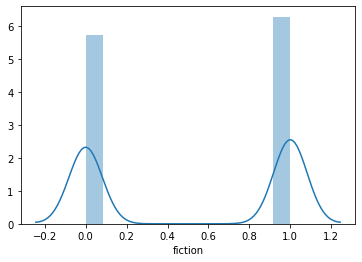

In [9]:
# === Target distribution === #
print(y_train.value_counts())
sns.distplot(y_train);

#### Majority class baseline

In [10]:
# === Use mode as predictions === #
maj = y_train.mode()[0]  # Mode is 1 (fiction)

# Simply predict 1 for every training example
y_pred_maj = [maj] * len(y_train)

# Baseline accuracy
accuracy_score(y_train, y_pred_maj)

0.5234241908006815

#### Limited logistic baseline

In [11]:
# === Use only a few features for this baseline === #
base_features = [
    "num_reviews",
    "avg_rating",
    "num_pages",
]

# Arrange X matrices
X1_train = train[base_features]
X1_val = val[base_features]
X1_test = test[base_features]

X1_train.shape, X1_val.shape, X1_test.shape

((11740, 3), (2935, 3), (3669, 3))

In [12]:
# === Baseline model === #
pipe1 = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ("logreg", LogisticRegression(random_state=92)),
])

# Train base pipeline
pipe1.fit(X1_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('logreg', LogisticRegression(random_state=92))])

In [13]:
# === Made predictions to get validation accuracy === #
y_pred1 = pipe1.predict(X1_val)

# Compute accuracy
print("Baseline accuracy:", accuracy_score(y_val, y_pred1))

Baseline accuracy: 0.6275979557069846


In [14]:
# === Baseline confusion matrix === #
confusion_matrix(y_val, y_pred1)

array([[ 821,  578],
       [ 515, 1021]])

#### Default Random Forest

In [15]:
# === Default random forest model === #
def_drop_columns = [
    "title",
    "author",
    "language",
]

X2_train = X_train.drop(columns=def_drop_columns)
X2_val = X_val.drop(columns=def_drop_columns)
X2_test = X_test.drop(columns=def_drop_columns)

rf1_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf1_pipe.fit(X2_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf1 = rf1_pipe.predict(X2_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf1))
print("  F1 score:", f1_score(y_val, y_pred_rf1))

Default random forest eval metrics:
  Accuracy: 0.7342419080068143
  F1 score: 0.7477360931435963


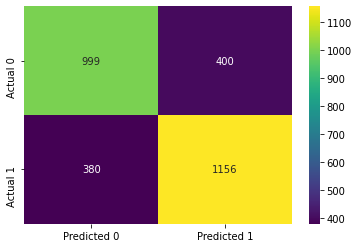

In [16]:
# === Evaluate default rf with confusion matrix === #
from sklearn.utils.multiclass import unique_labels

unique_labels(y_val)  # Create unique labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

# Plot the confusion matrix
plot_confusion_matrix(y_val, y_pred_rf1);

Alrighty then! With the (almost) full set of features and default hyperparameters the target can be predicted with ~73% accuracy. Although the target is not skewed very much, it is still skewed. Therefore, accuracy may not be the best way to evaluate the model. A better metric could be the F1 score. This is a little higher than the accuracy, clocking in at almost 75%.

The F1 score is made up of the precision and recall. Actually, it can be interpreted of as the weighted average of precision and recall.

This provides a better method of evaluating performance, because it takes into account false positives and false negatives. Accuracy only accounts for the model's correct predictions and mistakes, irrespective of _how_ the model made those mistakes.

In [17]:
# === Calculate precision === #
true_pos = 1156
false_pos = 400
precision = true_pos / (true_pos + false_pos)
print(f"Precision: {precision}")

Precision: 0.7429305912596401


In [18]:
# === Calculate recall === #
true_pos = 1156
false_neg = 380
recall = true_pos / (true_pos + false_neg)
print(f"recall: {recall}")

recall: 0.7526041666666666


In [19]:
# === Classification report === #
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1399
           1       0.74      0.75      0.75      1536

    accuracy                           0.73      2935
   macro avg       0.73      0.73      0.73      2935
weighted avg       0.73      0.73      0.73      2935



Let's see what we can do to increase that score.

---

## Iterate

* [x] Engineer new features
* [x] Feature pruning with permutation importance
* [x] Use cross-validation (RandomizedSearchCV) to tune hyperparameters
* [x] Try out different algorithms
  * [x] KNearestClassifier
  * [x] XGBClassifier

### Feature Engineering

When I initially started this project, I went through the process of validating and training a model or two that tried to predict the average rating of books. This was by far the most common target chosen by those who started Kaggle kernels using other GoodReads datasets. Although this may have the most obvious business value if I was a data scientist working for a book publisher, to me this wasn't a particularly interesting target to try to predict.

I realized this when I hit a wall with my progress in improving the rating-predictor model. One reason was that I did not see any obvious useful features that could be engineered. However, once I found my way to the idea of predicting the fictionality of the books, the target drove the direction I took with my feature engineering. It was a great learning experience for me in engineering features toward the specific target that the model is trying to predict.

Here are the feature ideas I came up with and engineered (all in short succession once the new target was chosen):

- [x] Title begins with "The"
- [x] Has subtitle: contains ":"
- [x] Title character count
- [x] Title word count
- [x] Title longest word
- [x] Author number of names
- [x] Author middle initial
- [x] Ratings (stars) ratio (1 + 2 / 4 + 5)

In [20]:
def engineer_features(data):
    """Engineer a handful of new features."""
    # Create new feature that is if the title begins with "The"
    data["the_title"] = data["title"].str.startswith("The")
    # New feature - has_subtitle
    data["has_subtitle"] = data["title"].str.contains(":")
    # New feature - title character length
    data["title_char_count"] = data["title"].apply(lambda x: len(x))
    # New feature - title word count
    data["title_word_count"] = data["title"].apply(lambda x: len(x.split()))
    # New feature - title longest word
    data["title_longest_word"] = data["title"].apply(lambda x: len(max(x.split(), key=len)))
    # New feature - author number of names
    data["author_name_count"] = data["author"].apply(lambda x: len(x.split()))
    # New feature - author middle initial
    pat = r"\w* (\w. )+ \w*"
    data["author_middle_initial"] = data["author"].str.contains(pat, regex=True)
    # New feature - low/high rating ratio
    data["rating_ratio"] = (data["1_rating_count"] + data["2_rating_count"]) / (data["4_rating_count"] + data["5_rating_count"])
    # Replace Boolean with binary
    data = data.replace(to_replace={True: 1, False:0})
    return data

#### Same random forest with additional features

In [21]:
# === Random forest model, new features === #
X3_train = engineer_features(X_train)
X3_val = engineer_features(X_val)
X3_test = engineer_features(X_test)

rf2_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf2_pipe.fit(X3_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf2 = rf2_pipe.predict(X3_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf2))
print("  F1 score:", f1_score(y_val, y_pred_rf2))

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Default random forest eval metrics:
  Accuracy: 0.7761499148211244
  F1 score: 0.7884057971014492


Got an extra ~3-4% out of those new features!

And that is with the default RandomForestClassifier hyperparameters and the SimpleImputer. For the next iteration, I will try using the IterativeImputer, then utilize RandomizedSearchCV to tune the hyperparameters and conduct cross-validation.

### Permutation Importances

It is likely that some of the features do not help the model make correct predictions. Indeed, some may even be worse than that: they could add noise that makes the model perform worse.

To address this potential problem, I'm going to find the feature importances using a method called permutation importance. Basically, this method will go through each of the features, replacing their data with random noise generated from the distribution of the original data. The performance of the model will be evaluated and compared with the score using all of the original data to find the effect of each feature on the performance of the model.

In [22]:
# === Transformer pipeline === #
# Use the same (fitted) steps from main pipeline
transformers = Pipeline([
    ("encoder", rf2_pipe.named_steps["encoder"]),
    ("imputer", rf2_pipe.named_steps["imputer"]),
])

# Encode and impute
X3_train_transformed = transformers.transform(X3_train)
X3_val_transformed = transformers.transform(X3_val)

In [23]:
# === Instantiate and fit the permuter === #
permuter = PermutationImportance(
    rf2_pipe.named_steps["rfc"], 
    scoring='f1', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X3_val_transformed, y_val)

PermutationImportance(estimator=RandomForestClassifier(random_state=92),
                      random_state=42, scoring='f1')

In [24]:
# === Get permutation importances === #
feature_names = X3_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # Show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0307 ± 0.0021,has_subtitle
0.0264 ± 0.0116,avg_rating
0.0197 ± 0.0066,4_rating_count
0.0193 ± 0.0031,publish_year
0.0153 ± 0.0059,num_ratings
0.0124 ± 0.0039,series
0.0116 ± 0.0071,1_rating_count
0.0096 ± 0.0048,num_pages
0.0078 ± 0.0099,num_reviews
0.0073 ± 0.0091,3_rating_count


Based on the above table, I should see either no change or a small increase in the model's performance by removing `publish_month`, `author`, `title_word_count`, `title`, and `publish_day`. I'm going to try removing those and training the model again.

As for the rest of the features, I find it interesting to see what features have the largest positive effect on the model's predictive power. From this table, I can see that the majority of the benefit I got from engineering the new features came from the `has_subtitle` feature. This feature, according to the permutation importance table, is the most important predictor by quite a long shot and accounted for 0.04 simply indicates whether the title of the book has a colon in it. My intuition was that having a subtitle is very common for nonfiction books, not so much for fiction.

In [25]:
# === Prune the features === #
more_drop_cols = [
    "publish_month",
    "author",
    "title_word_count",
    "title",
    "publish_day",
]

# New features are already engineered
X4_train = X3_train.drop(columns=more_drop_cols)
X4_val   = X3_val.drop(columns=more_drop_cols)
X4_test  = X3_test.drop(columns=more_drop_cols)

In [26]:
# === Random forest model with pruned features === #
rf3_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf3_pipe.fit(X4_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf3 = rf3_pipe.predict(X4_val)

# Compute evaluation metrics
print("Default random forest:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf3))
print("  F1 score:", f1_score(y_val, y_pred_rf3))

Default random forest:
  Accuracy: 0.7867120954003407
  F1 score: 0.7991014120667522


It seems that removing the features indicated did have a positive effect of about 0.01 on the model's performance.

In [27]:
# === Logistic regression, pruned features === #
lg_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ("lg", LogisticRegression(random_state=92)),
])

# Train default logistic model
lg_pipe.fit(X4_train, y_train)

# Made predictions to get validation accuracy
y_pred_lg = lg_pipe.predict(X4_val)

# Compute evaluation metrics
print("Default logistic model:")
print("  Accuracy:", accuracy_score(y_val, y_pred_lg))
print("  F1 score:", f1_score(y_val, y_pred_lg))

Default logistic model:
  Accuracy: 0.7315161839863714
  F1 score: 0.7612121212121213


Based on the performance of the logistic model, it does seem that random forest is a good model for the problem at hand.

### Cross-validation + Hyperparameter tuning

Though I don't have a record of every single iteration of the hyperparameter searches, the method I used to tune is to basically look at the values of each parameter, and moved the search range to more closely fit around those values.

The resulting performances from the models that I ran through the hyperparameter tuning and cross-validation process were actually on par with the default random forest model that did not use cross-validation.

It could be that the best estimator from the search would outperform the previous one when predicting the test data. Or, it could be that the parameters and their ranges I'm searching are not optimal. Or, I simply did not provide enough of a search window to find the best combination of parameters. That is, I could try increasing the number of iterations in the randomized search to hopefully increase the chances of finding the optimal combination.

Ultimately, I decided to try out some other algorithms to see if they might be a better fit for this problem and dataset: logistic regression (with full featureset), k-nearest neighbors, and gradient-boosted decision tree.

#### Logistic regression

With the full featureset (after pruning), a basic logistic model was able to get an F1 score of about .76.

#### Nearest Neighbors

The third type of model I trained was a nearest neighbors model using Scikit-Learn's KNeighborsClassifier algorithm.

The trained KNeighborsClassifier model was the worst-performing of the lot, clocking in with an F1 score of just under .70.

It seems that Random Forest is quite a bit better of an algorithm for this problem than k-nearest neighbors, or even logistic regression. Therefore, I didn't move forward with nearest neighbors. I mostly wanted to just try it out anyways.

#### Gradient Boosting

The fourth and final type of model I trained was a gradient-boosted decision tree using [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

I was surprised to find that my attempts at training the `XGBClassifier` had about the same performance as the default random forest with the newly-engineered features.

As I mentioned above, one hypothesis of what was causing the discrepancy (or lack thereof: I assumed gradient-boosting would increase the performance, which maybe wasn't a sound assumption), could be the simple fact that the randomized search doesn't cover every possibility. To test this, I increased the number of iterations and let 'er rip!

#### More Random Forests

Even with 40 total fits (4 cross-validation folds, 10 iterations) the gradient-boosted classifier did not really outperform the random forest by any significant margin. Given the additional complexity and computation required for an XGBoost model, I'm going to use the random forest classifier instead.

To continue testing the hypothesis that my initial number of iterations was too low for the search to converge on a good combination of hyperparameters, I'm going to train more random forests. This time, I'm going to try running the random search with a higher number of iterations. If that seems promising, I'm going to further tune the hyperparameters and look into any additional hyperparameters that might be good to include in the tuning process.

### Back to val

Somewhat to my surprise, the best performance of the models achieved through hyperparameter tuning and cross-validation was on par with the default random forest model that did not use cross-validation. That held true even when using a gradient-boosted algorithm.

Therefore, to simplify things, the final model I used was the default random forest with a manual validation set.

In [28]:
# === But how does it perform on the test data? === #
y_pred_test_rf3 = rf3_pipe.predict(X4_test)

# Compute evaluation metrics
print("Random forest 4 eval metrics:")
print("  Accuracy:", accuracy_score(y_test, y_pred_test_rf3))
print("  F1 score:", f1_score(y_test, y_pred_test_rf3))

Random forest 4 eval metrics:
  Accuracy: 0.7664213682202234
  F1 score: 0.7791806235506312


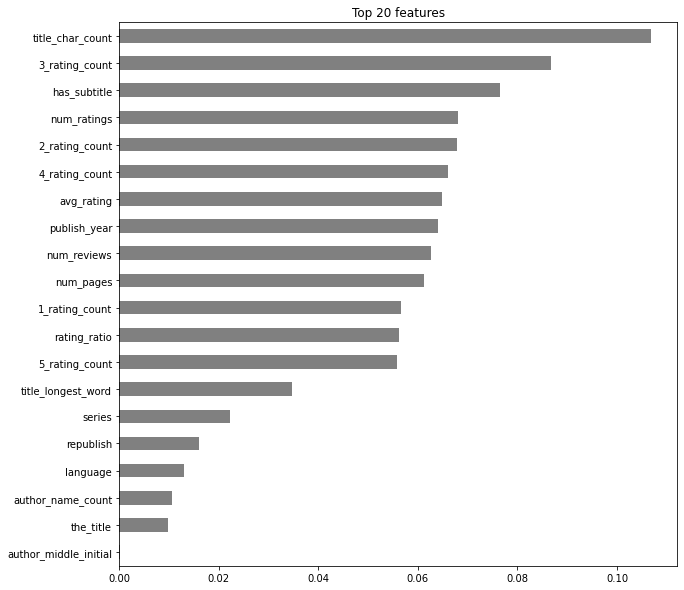

In [29]:
# === Get feature importances === #
rf3 = rf3_pipe.named_steps["rfc"]
importances = pd.Series(rf3.feature_importances_, X4_train.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

---

## Results and Interpretation

I tried many different combinations of different hyperparameters and the best F1 score I was able to achieve was just north of .79. Even with all of my tuning, I never beat the F1 score that was achieved with the random forest classifier using default hyperparameters.

One final step to be taken before deployment is to inspect the predictions that the model made on the test set, looking at the predicted probabilities that resulted in each of the predictions. By looking at the predicted probabilities, I can look at instances when the model was sure or unsure of its predictions, and if those predictions were correct or not.

This can provide some insight into the reasons for the model being incorrect, which could be valuable information to have, particularly when attempting to interpret (the results of) the model.

#### Predicted probabilities

In [30]:
# Get indexes as an id field to match up on later
train_id = X4_train.reset_index()["index"]
test_id = X4_test.reset_index()["index"]

In [31]:
test_id.head()

0     1042
1    10779
2    10072
3    15540
4    13007
Name: index, dtype: int64

In [33]:
# === ROC AUC + predicted probabilities === #
from sklearn.metrics import roc_auc_score

# Process the test data
transformers_2 = Pipeline([
    ("encoder", rf3_pipe.named_steps["encoder"]),
    ("imputer", rf3_pipe.named_steps["imputer"]),
])

# Encode and impute
X4_test_transform = transformers_2.transform(X4_test)
class_index = 1

# Make predictions with the trained random forest
y_pred_proba_rf3 = rf3.predict_proba(X4_test_transform)[:, class_index]

# ROC AUC score ranges from 0-1; higher is better
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba_rf3))

Test ROC AUC for class 1:
0.8508187240388956


In [34]:
# === Reset index of test set to get column to match on === #
X4_test = X4_test.reset_index()
X4_test.head()

,index,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,author_middle_initial,rating_ratio
0,1042,112871.0,4674.0,4.00,317.0,English,0,1593.0,5439.0,24255.0,41993.0,39591.0,1997.0,1,0,0,29,7,2,0,0.086193
1,10779,364.0,47.0,3.97,431.0,English,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0,0.106061
2,10072,49.0,12.0,4.18,294.0,English,0,0.0,3.0,10.0,11.0,25.0,1994.0,0,0,0,16,8,2,0,0.083333
3,15540,150.0,14.0,3.87,200.0,English,1,0.0,2.0,46.0,71.0,31.0,1994.0,0,0,0,16,6,2,0,0.019608
4,13007,19322.0,213.0,4.09,268.0,English,1,285.0,986.0,3758.0,5984.0,8309.0,1993.0,1,0,1,40,11,2,0,0.088925


In [35]:
X4_test.shape, test_id.shape, y_pred_proba_rf3.shape, y_test.shape

((3669, 21), (3669,), (3669,), (3669,))

In [36]:
y_test.reset_index().head()

,index,fiction
0,1042,1
1,10779,0
2,10072,0
3,15540,1
4,13007,1


In [37]:
# === Compare true / pred === #
# Create new dataframe to compare the predictions to the actual
df = pd.DataFrame({
    "index": test_id,
    "pred": y_pred_test_rf3,
    "pred_proba": y_pred_proba_rf3,
})

print(df.shape)
df.head()

(3669, 3)


,index,pred,pred_proba
0,1042,1,0.92
1,10779,1,0.57
2,10072,0,0.14
3,15540,1,0.63
4,13007,1,0.58


In [38]:
# === Merge in actuals === #
df = df.merge(y_test.reset_index())

print(df.shape)
df.head()

(3669, 4)


,index,pred,pred_proba,fiction
0,1042,1,0.92,1
1,10779,1,0.57,0
2,10072,0,0.14,0
3,15540,1,0.63,1
4,13007,1,0.58,1


In [39]:
# === Merge the rest of the features back in === #
df = df.merge(
     X4_test,
     how='left'
)

print(df.shape)
df.head()

(3669, 24)


,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,author_middle_initial,rating_ratio
0,1042,1,0.92,1,112871.0,4674.0,4.00,317.0,English,0,1593.0,5439.0,24255.0,41993.0,39591.0,1997.0,1,0,0,29,7,2,0,0.086193
1,10779,1,0.57,0,364.0,47.0,3.97,431.0,English,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0,0.106061
2,10072,0,0.14,0,49.0,12.0,4.18,294.0,English,0,0.0,3.0,10.0,11.0,25.0,1994.0,0,0,0,16,8,2,0,0.083333
3,15540,1,0.63,1,150.0,14.0,3.87,200.0,English,1,0.0,2.0,46.0,71.0,31.0,1994.0,0,0,0,16,6,2,0,0.019608
4,13007,1,0.58,1,19322.0,213.0,4.09,268.0,English,1,285.0,986.0,3758.0,5984.0,8309.0,1993.0,1,0,1,40,11,2,0,0.088925


In [53]:
# === Filter for incorrect predictions === #
df_wrong = df[df["pred"] != df["fiction"]]
print(df_wrong.shape)
df_wrong.head()

(857, 24)


,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,author_middle_initial,rating_ratio
1,10779,1,0.57,0,364.0,47.0,3.97,431.0,English,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0,0.106061
7,5437,1,0.70,0,2650.0,92.0,3.96,304.0,English,0,49.0,154.0,590.0,927.0,930.0,1987.0,1,1,0,45,9,2,0,0.109316
9,9875,1,0.66,0,3073.0,82.0,4.25,659.0,English,0,22.0,65.0,469.0,1091.0,1426.0,1976.0,1,1,0,17,8,2,0,0.034565
10,2513,0,0.25,1,1471.0,345.0,3.80,308.0,English,1,96.0,142.0,298.0,358.0,577.0,2011.0,0,0,0,8,8,2,0,0.254545
13,3274,0,0.13,1,60322.0,2623.0,4.04,365.0,English,0,377.0,2063.0,12538.0,25237.0,20107.0,2005.0,1,0,1,46,9,2,0,0.053811


In [55]:
# === Get titles, because I'm curious === #
df_wrong = df_wrong.merge(books.iloc[df_wrong["index"]]["title"].reset_index())
print(df_wrong.shape)
df_wrong.head(32)

(857, 25)


,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,author_middle_initial,rating_ratio,title
0,10779,1,0.57,0,364.0,47.0,3.97,431.0,English,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0,0.106061,Whispers of Heaven
1,5437,1,0.70,0,2650.0,92.0,3.96,304.0,English,0,49.0,154.0,590.0,927.0,930.0,1987.0,1,1,0,45,9,2,0,0.109316,The Condition of the Working Class in England
2,9875,1,0.66,0,3073.0,82.0,4.25,659.0,English,0,22.0,65.0,469.0,1091.0,1426.0,1976.0,1,1,0,17,8,2,0,0.034565,The Portable Jung
3,2513,0,0.25,1,1471.0,345.0,3.80,308.0,English,1,96.0,142.0,298.0,358.0,577.0,2011.0,0,0,0,8,8,2,0,0.254545,Creatura
4,3274,0,0.13,1,60322.0,2623.0,4.04,365.0,English,0,377.0,2063.0,12538.0,25237.0,20107.0,2005.0,1,0,1,46,9,2,0,0.053811,Smoke and Mirrors: Short Fiction and Illusions
5,18101,0,0.34,1,227.0,15.0,4.15,236.0,English,1,3.0,9.0,40.0,75.0,100.0,2011.0,1,0,0,6,6,3,0,0.068571,Tempus
6,2960,0,0.50,1,30195.0,5083.0,4.19,360.0,English,0,804.0,1225.0,3935.0,9587.0,14644.0,2011.0,0,0,0,12,4,3,0,0.083736,Okay for Now
7,14775,1,0.64,0,111.0,49.0,3.98,394.0,English,0,0.0,10.0,21.0,41.0,39.0,2015.0,1,0,0,16,4,2,0,0.125000,Five Suns Saga I
8,16221,0,0.44,1,283.0,18.0,3.95,96.0,English,1,5.0,18.0,77.0,69.0,114.0,1994.0,1,1,0,21,5,3,0,0.125683,The Fox and the Hound
9,5396,0,0.50,1,12296.0,1649.0,4.32,302.0,English,0,125.0,360.0,1485.0,3777.0,6549.0,2006.0,0,0,0,10,6,3,0,0.046969,Copper Sun


From a brief read through the above table of some incorrect predictions, one of the common mistakes the model makes is to trust the `has_subtitle` feature too much. There does seem to be some fiction books that have subtitles, seemingly many of which cause the model to predict as nonfiction.